In [3]:
from diffusers import StableDiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
from PIL import Image
from diffusers import AutoencoderKL

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

"device: {}".format(device)

'device: cuda'

In [22]:
model_id = "runwayml/stable-diffusion-v1-5"

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)                                                                                                                                        

pipeline = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
    )

pipeline.vae = vae
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    pipeline.scheduler.config)

pipeline.enable_xformers_memory_efficient_attention()

vae.to(device)
pipeline = pipeline.to(device)

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 94042.69it/s]
/home/meegan1/Projects/ML/StabilityDiffuser/.venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [24]:
from compel import Compel

compel_proc = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)

def get_inputs(prompt, batch_size=1):
    generator = [torch.Generator("cpu").manual_seed(i)
                 for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 20
    prompt_embeds = compel_proc(prompts)

    return {"prompt_embeds": prompt_embeds, "generator": generator, "num_inference_steps": num_inference_steps}


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols*w, i//cols*h))
    return grid

In [19]:
prompt = "chocolate bar in a field, ultrarealistic, photograph"
# prompt += " 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta"

prompt

'chocolate bar in a field, ultrarealistic, photograph'

100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


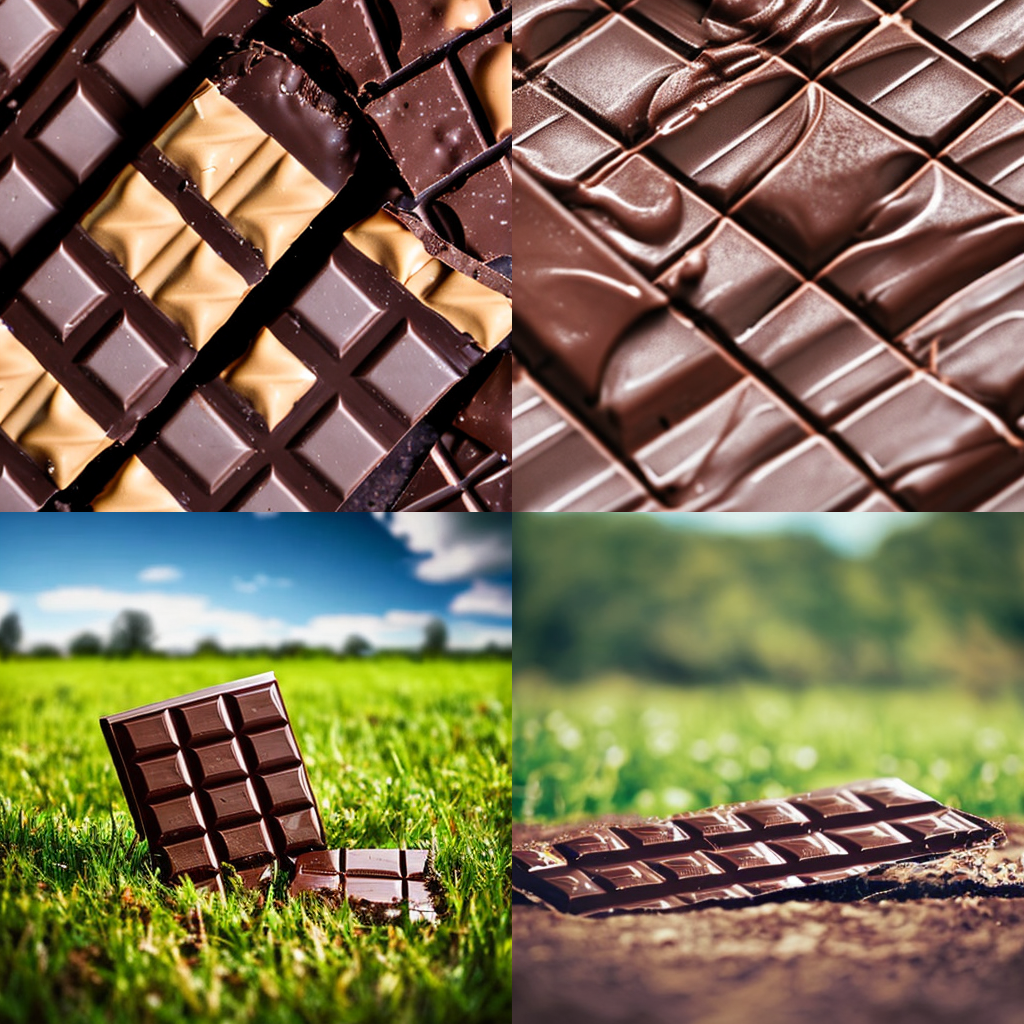

In [25]:
images = pipeline(**get_inputs(prompt=prompt, batch_size=4)).images
image_grid(images)